In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification


In [10]:
test_df = pd.read_pickle("finbert_test_df.pkl")

X_text = test_df["text"].tolist()
y_true = test_df["label_id"].values


In [12]:
import joblib
import os

WEEK2_DIR = "../week2"   # adjust if needed

tfidf = joblib.load(os.path.join(WEEK2_DIR, "week2_tfidf_vectorizer.joblib"))
lr_model = joblib.load(os.path.join(WEEK2_DIR, "week2_lr_model.joblib"))
nb_model = joblib.load(os.path.join(WEEK2_DIR, "week2_nb_model.joblib"))
knn_model = joblib.load(os.path.join(WEEK2_DIR, "week2_knn_model.joblib"))

X_tfidf = tfidf.transform(X_text)

lr_preds  = lr_model.predict(X_tfidf)
nb_preds  = nb_model.predict(X_tfidf)
knn_preds = knn_model.predict(X_tfidf)


In [13]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

def vader_label(text):
    s = sia.polarity_scores(text)["compound"]
    if s > 0.05:
        return 0   # positive
    elif s < -0.05:
        return 1   # negative
    else:
        return 2   # neutral

vader_preds = np.array([vader_label(t) for t in X_text])


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

finbert_path = "./finbert_finetuned/best_model"
tokenizer = AutoTokenizer.from_pretrained(finbert_path)
model = AutoModelForSequenceClassification.from_pretrained(finbert_path).to(device)
model.eval()

def finbert_predict(texts, batch_size=32):
    preds = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
        preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
    return np.array(preds)

finbert_preds = finbert_predict(X_text)


In [15]:
def metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average="weighted", zero_division=0),
        "recall": recall_score(y_true, y_pred, average="weighted", zero_division=0),
        "f1": f1_score(y_true, y_pred, average="weighted", zero_division=0)
    }

results = {
    "VADER (Lexicon)": metrics(y_true, vader_preds),
    "Logistic Regression": metrics(y_true, lr_preds),
    "Naive Bayes": metrics(y_true, nb_preds),
    "KNN": metrics(y_true, knn_preds),
    "FinBERT (Fine-tuned)": metrics(y_true, finbert_preds)
}

comparison_df = pd.DataFrame(results).T
comparison_df


,accuracy,precision,recall,f1
VADER (Lexicon),0.525447,0.591925,0.525447,0.532057
Logistic Regression,0.745530,0.739974,0.745530,0.733295
Naive Bayes,0.696011,0.715809,0.696011,0.649924
KNN,0.683631,0.666150,0.683631,0.668757
FinBERT (Fine-tuned),0.895461,0.896792,0.895461,0.895817


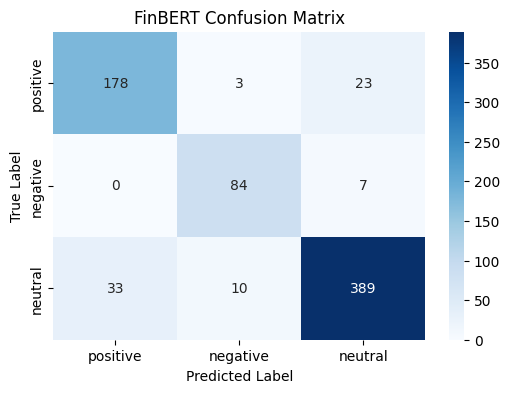

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, finbert_preds)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["positive","negative","neutral"],
            yticklabels=["positive","negative","neutral"])
plt.title("FinBERT Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()
